# Map a city by its OpenStreetMap nodes

This uses the overpass API:

- https://wiki.openstreetmap.org/wiki/Overpass_API/Language_Guide
- https://wiki.openstreetmap.org/wiki/Overpass_API/Overpass_QL
- http://overpass-turbo.eu/#
- http://overpass-api.de/query_form.html

In [1]:
import overpy, time, pickle, os, matplotlib.pyplot as plt
from geopandas import GeoDataFrame
from shapely.geometry import Point
%matplotlib inline

In [2]:
# define bounding box to download all of Manhattan and CRS to project it
#bbox_south = 40.680458
#bbox_west = -74.027254
#bbox_north = 40.882451
#bbox_east = -73.907778
#utm_crs = {'datum':'NAD83', 'ellps':'GRS80', 'proj':'utm', 'zone':18, 'units':'m'}

In [3]:
# define bounding box to download all of SF and CRS to project it
bbox_south = 37.708
bbox_west = -122.517
bbox_north = 37.811
bbox_east = -122.357
utm_crs = {'datum':'NAD83', 'ellps':'GRS80', 'proj':'utm', 'zone':11, 'units':'m'}

## Download node data from OSM

In [4]:
# build the node query with bounding box as south,west,north,east
bbox = '{},{},{},{}'.format(bbox_south, bbox_west, bbox_north, bbox_east)
node_query = 'node({});out;'.format(bbox)

In [5]:
# location of pickle file to use as local cache for the OSM response
pickle_filename = 'data/overpy_response_{}.pickle'.format(bbox).replace(',', '_')

In [6]:
start_time = time.time()
if os.path.isfile(pickle_filename):
    # if pickle file for this bounding box already exists, load nodes from this local cache
    pickle_file = open(pickle_filename, 'rb')
    response = pickle.load(pickle_file)
    print('Loaded {:,} nodes from disk in {:,.2f} seconds'.format(len(response.nodes), time.time()-start_time))
else:
    # if pickle file for this bounding box doesn't exist yet, download nodes from OSM
    overpass = overpy.Overpass()
    response = overpass.query(node_query)
    print('Downloaded {:,} nodes from OSM in {:,.2f} seconds'.format(len(response.nodes), time.time()-start_time))
    
    # save response to pickle file so we can re-use without repeating the API query
    pickle_file = open(pickle_filename, 'wb')
    pickle.dump(response, pickle_file)

Downloaded 1,758,850 nodes from OSM in 650.74 seconds


## Project the lat-long data

In [7]:
# create a geodataframe, add lat-long, and create a geometry column of shapely points
gdf = GeoDataFrame()
gdf['lat'] = [float(node.lat) for node in response.nodes]
gdf['lon'] = [float(node.lon) for node in response.nodes]
gdf['geometry'] = gdf.apply(lambda row: Point(row['lon'], row['lat']), axis=1)

In [8]:
# set the original (lat-long) CRS then project the geodataframe to the target CRS
original_crs = {'datum':'WGS84', 'ellps':'WGS84', 'proj':'latlong'}
gdf.crs = original_crs
gdf = gdf.to_crs(utm_crs)

In [9]:
# extract x and y columns from the projected geometry for easy scatter-plotting
gdf['x'] = gdf['geometry'].map(lambda point: point.x)
gdf['y'] = gdf['geometry'].map(lambda point: point.y)
gdf.head()

,lat,lon,geometry,x,y
0,37.779281,-122.419236,POINT (22604.40450301376 4195180.729095829),22604.404503,4.195181e+06
1,37.709545,-122.395135,POINT (24281.33045814343 4187311.938476464),24281.330458,4.187312e+06
2,37.711865,-122.395722,POINT (24244.38092316792 4187572.539783953),24244.380923,4.187573e+06
3,37.716950,-122.398901,POINT (23996.57636640576 4188153.534094794),23996.576366,4.188154e+06
4,37.713237,-122.396452,POINT (24188.81318970851 4187728.737920357),24188.813190,4.187729e+06


## Plot the projected data

In [10]:
# make the plotting figure size proportional to the projected data's spatial extent
fig_height = 30
bbox_aspect_ratio = (gdf['y'].max() - gdf['y'].min()) / (gdf['x'].max() - gdf['x'].min())
fig_width = fig_height * bbox_aspect_ratio

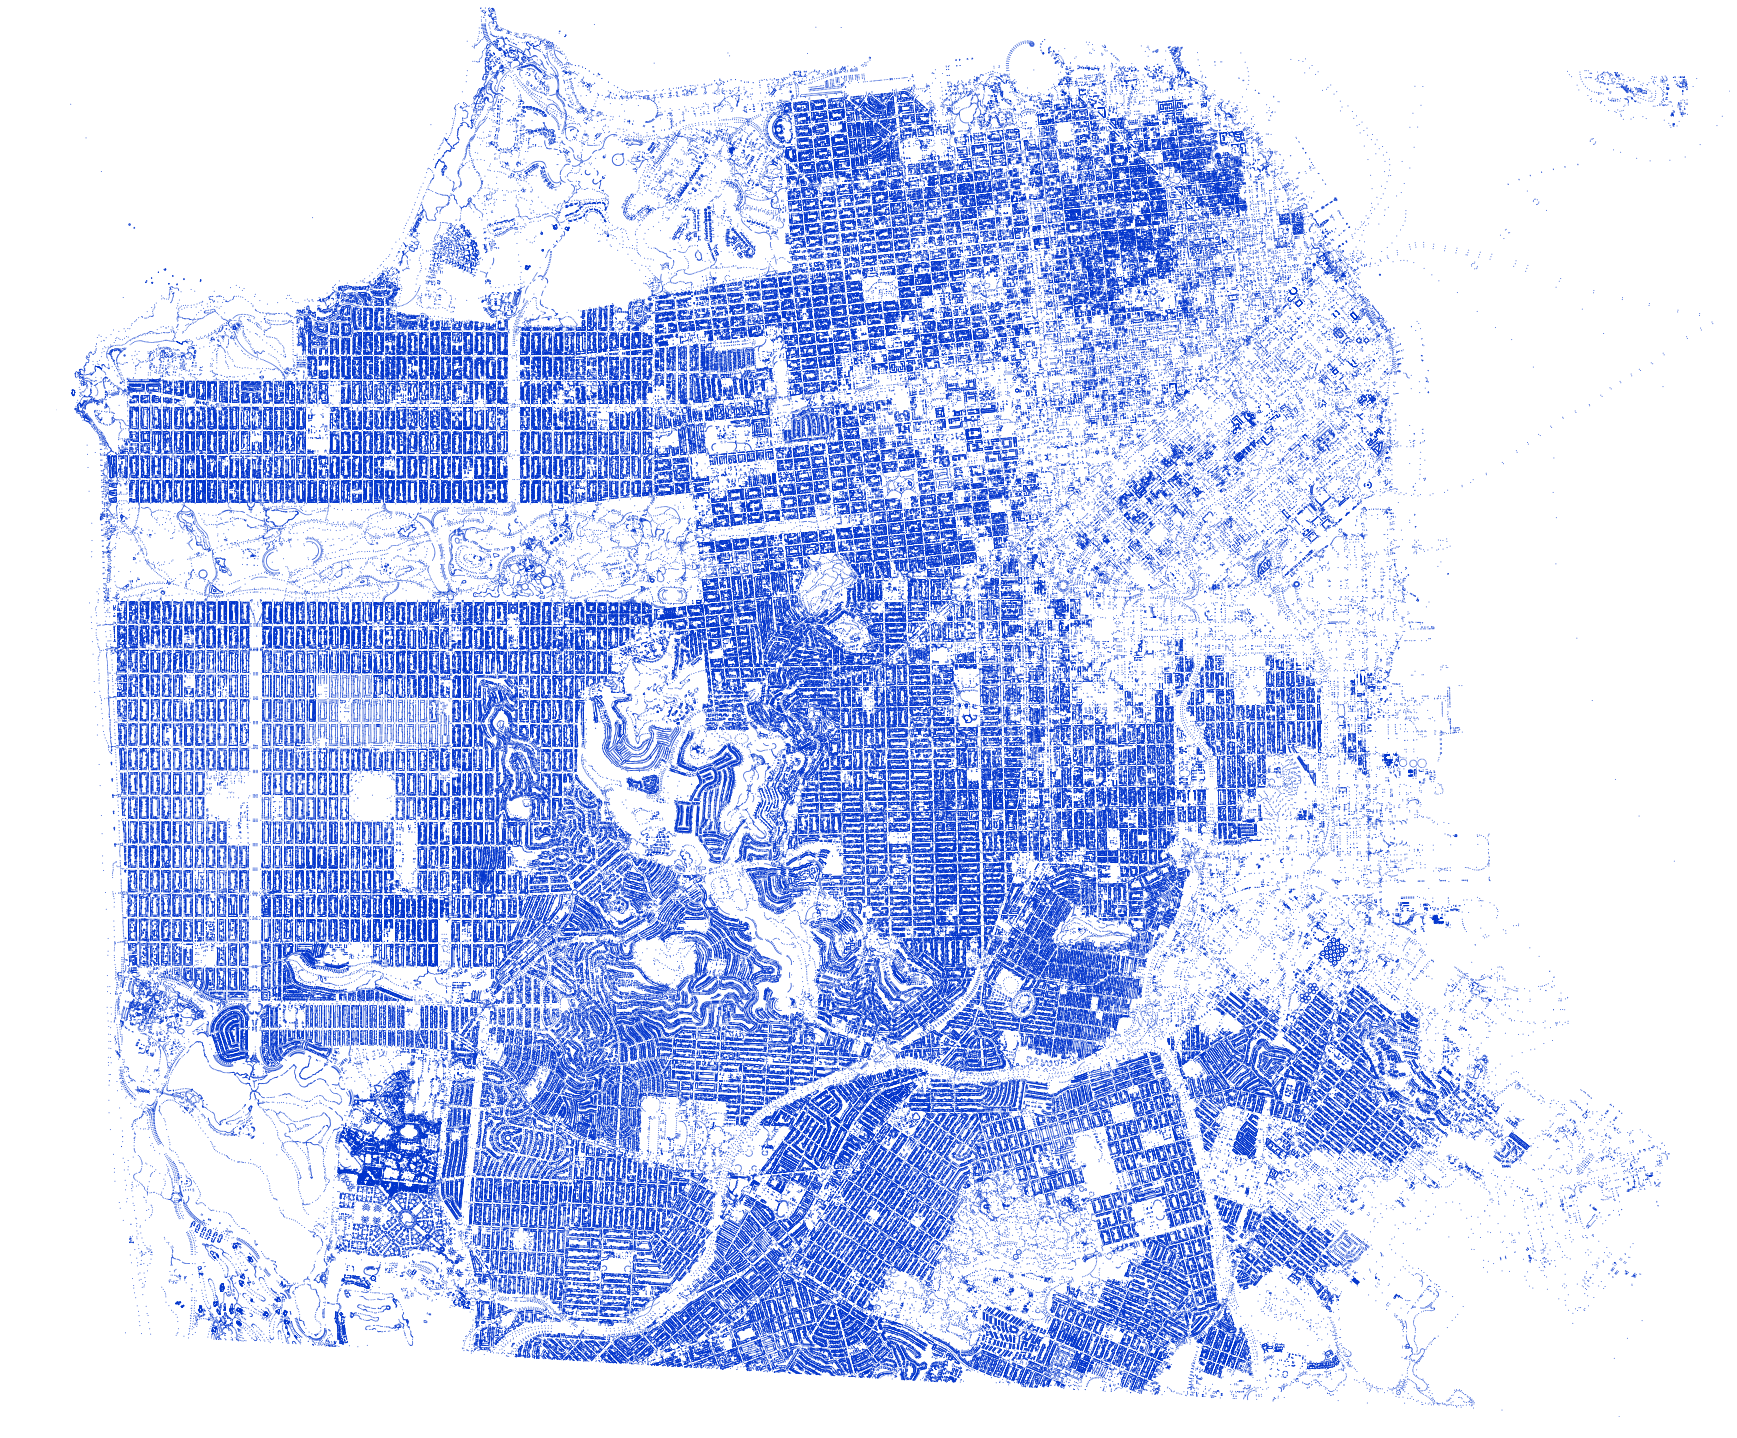

In [11]:
# plot the data
fig, ax = plt.subplots(figsize=(fig_height, fig_width))
ax.scatter(gdf['x'], gdf['y'], s=1, c='#0033cc', edgecolor='None', alpha=0.8)
ax.set_ylim(gdf['y'].min(), gdf['y'].max())
ax.set_xlim(gdf['x'].min(), gdf['x'].max())
ax.axis('off')
filename = 'images/nodes_{}.jpg'.format(bbox).replace(',', '_')
fig.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()